In [14]:
from openbb import obb
from libs.backtester import Backtester
from backtesting import Strategy
#from backtesting.lib import crossover
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

plt.rcParams["figure.figsize"] = (15,7)
plt.style.use("dark_background")
pd.set_option('display.max_columns', None)

from dotenv import dotenv_values

config = dotenv_values(".env") 
obb.account.login(pat=config['OPENBB_PAT'])

In [15]:
def add_to_date(date_str, delta=None):
    # {'days: 365}
    delta = delta or {'days': 365}
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    new_date = date_obj + timedelta(**delta)
    new_date_str = new_date.strftime('%Y-%m-%d')
    return new_date_str

def capitalize_df_cols(df):
    mapper = { col: col.capitalize()  for col in df.columns }
    df.rename( mapper, axis=1, inplace=True)

In [19]:
start_date = '2010-01-01'
end_date = '2011-01-01'
price_qqq = obb.equity.price.historical('TQQQ', start_date=start_date, end_date=end_date, provider='yfinance').to_dataframe()
capitalize_df_cols(price_qqq)
price_qqq.head()

,Open,High,Low,Close,Volume,Split_ratio,Dividend,Capital_gains
date,,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,3456000,0.0,0.0,0.0
2010-02-12,0.420781,0.438073,0.418333,0.434323,8601600,0.0,0.0,0.0
2010-02-16,0.444531,0.452188,0.437552,0.451146,9619200,0.0,0.0,0.0
2010-02-17,0.457188,0.458906,0.450313,0.458802,19180800,0.0,0.0,0.0
2010-02-18,0.458333,0.470260,0.455573,0.467500,38860800,0.0,0.0,0.0


In [20]:
trates = obb.fixedincome.government.treasury_rates(start_date=start_date, end_date=end_date).to_dataframe()
capitalize_df_cols(trates)
trates.head()

,Month_1,Month_3,Month_6,Year_1,Year_2,Year_3,Year_5,Year_7,Year_10,Year_20,Year_30
date,,,,,,,,,,,
2010-01-04,0.0005,0.0008,0.0018,0.0045,0.0109,0.0166,0.0265,0.0336,0.0385,0.0460,0.0465
2010-01-05,0.0003,0.0007,0.0017,0.0041,0.0101,0.0157,0.0256,0.0328,0.0377,0.0454,0.0459
2010-01-06,0.0003,0.0006,0.0015,0.0040,0.0101,0.0160,0.0260,0.0333,0.0385,0.0463,0.0470
2010-01-07,0.0002,0.0005,0.0016,0.0040,0.0103,0.0162,0.0262,0.0333,0.0385,0.0462,0.0469
2010-01-08,0.0002,0.0005,0.0015,0.0037,0.0096,0.0156,0.0257,0.0331,0.0383,0.0461,0.0470


In [30]:
_df = pd.merge(price_qqq, trates[['Year_1']], how='inner', left_index=True, right_index=True)
_df['Returns'] = _df['Close'] - _df['Open']
_df['Returns_from_t0'] = ( _df['Close'] / _df['Open'].iloc[0] ) - 1
_df['Trates_1y'] = pd.to_numeric(_df['Year_1'], errors='coerce').fillna(0)
_df['Excess_returns'] = _df['Returns_from_t0'] - _df['Trates_1y']
_df['Sharpe'] = _df['Excess_returns'] / _df['Returns'].expanding().std()
# _df['Excess_returns'] = _df['Returns'] - _df['Trates_1y']
# _df['Sharpe'] = _df['Excess_returns'] / _df['Returns'].expanding().std()
ema_a = 5
ema_b = 20
_df[f'Sharpe_EMA_{ema_a}'] = ta.ema(_df['Sharpe'], ema_a).fillna(0)
_df[f'Sharpe_EMA_{ema_b}'] = ta.ema(_df['Sharpe'], ema_b).fillna(0)
_df

,Open,High,Low,Close,Volume,Split_ratio,Dividend,Capital_gains,Year_1,Returns,Returns_from_t0,Trates_1y,Excess_returns,Sharpe,Sharpe_EMA_5,Sharpe_EMA_20
date,,,,,,,,,,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,3456000,0.0,0.0,0.0,0.0038,0.025677,0.063108,0.0038,0.059308,NaN,0.000000,0.000000
2010-02-12,0.420781,0.438073,0.418333,0.434323,8601600,0.0,0.0,0.0,0.0035,0.013542,0.067461,0.0035,0.063961,7.453981,0.000000,0.000000
2010-02-16,0.444531,0.452188,0.437552,0.451146,9619200,0.0,0.0,0.0,0.0034,0.006615,0.108807,0.0034,0.105407,10.924360,0.000000,0.000000
2010-02-17,0.457188,0.458906,0.450313,0.458802,19180800,0.0,0.0,0.0,0.0035,0.001614,0.127624,0.0035,0.124124,11.902962,0.000000,0.000000
2010-02-18,0.458333,0.470260,0.455573,0.467500,38860800,0.0,0.0,0.0,0.0037,0.009167,0.149001,0.0037,0.145301,15.947968,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,0.775365,0.786458,0.758854,0.781979,32083200,0.0,0.0,0.0,0.0032,0.006614,0.921915,0.0032,0.918715,63.847246,63.328687,58.573106
2010-12-28,0.787813,0.788490,0.773281,0.778594,31737600,0.0,0.0,0.0,0.0031,-0.009219,0.913595,0.0031,0.910495,63.351874,63.336416,59.028227
2010-12-29,0.785469,0.787604,0.781250,0.783229,22732800,0.0,0.0,0.0,0.0030,-0.002240,0.924987,0.0030,0.921987,64.291705,63.654846,59.529510


<Axes: xlabel='date'>

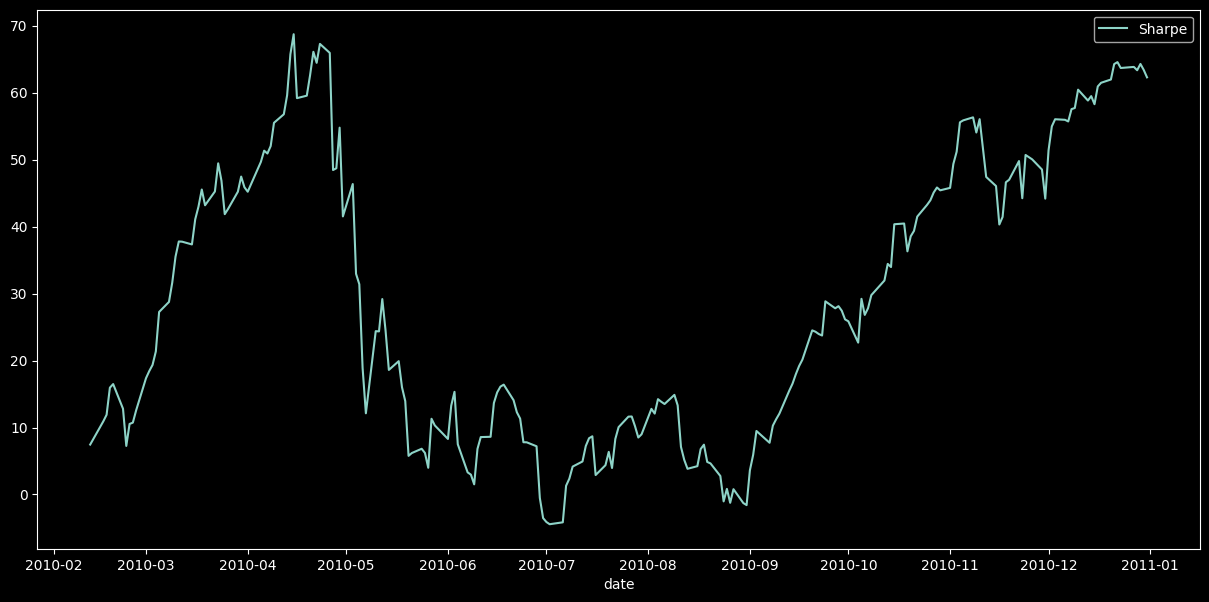

In [31]:
#_df[['Sharpe', f'Sharpe_EMA_{ema_a}', f'Sharpe_EMA_{ema_b}']].plot()
_df[['Sharpe']].plot()

<Axes: xlabel='Sharpe', ylabel='y'>

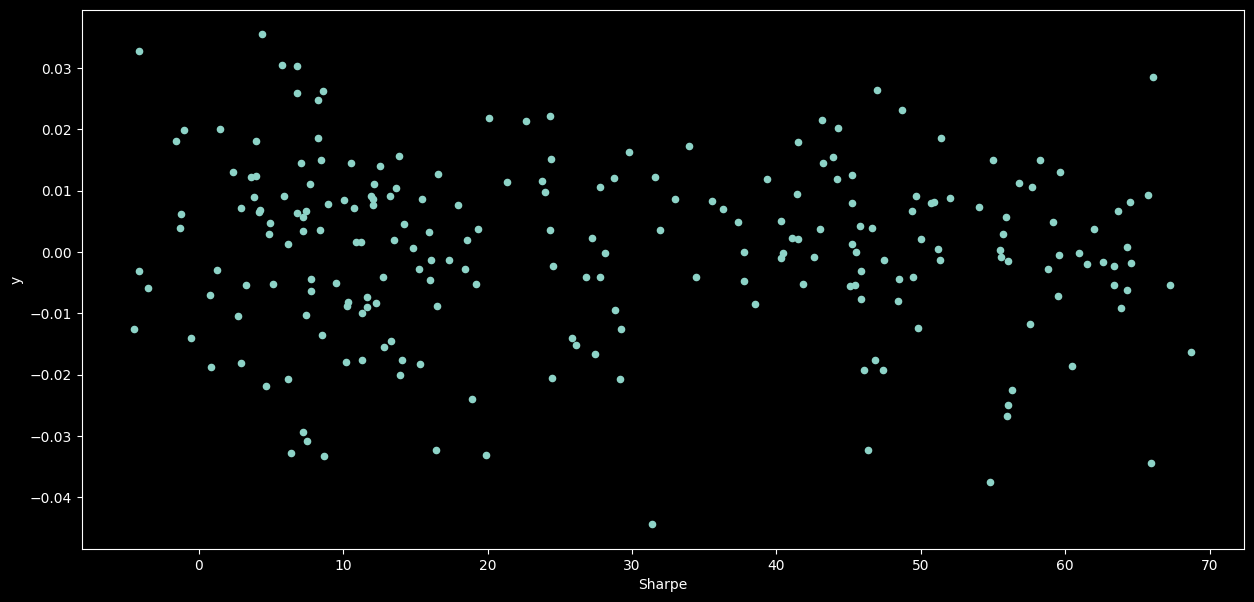

In [32]:
_df['y'] = _df['Returns'].shift(-1)
_df.plot.scatter(x='Sharpe', y='y')

```
df[f'Sharpe Signal {ema_a}'] = ( df[f'Sharpe Ema {ema_a}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)
df[f'Sharpe Signal {ema_b}'] = ( df[f'Sharpe Ema {ema_b}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)

def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

df['Sharpe Signal'] = crossover_signal(df[f'Sharpe Signal {ema_a}'].values, df[f'Sharpe Signal {ema_b}'].values)
df
```

```
df['Sharpe below'] = (df['Sharpe Ema 20'] - df['Sharpe']).apply(lambda v: v if v > 0 else 0)
```

In [8]:
df_signals = pd.read_csv("../data/QQQ_1999_2001_marked.csv")
df_signals.set_index(keys=["date"], inplace=True)
df_signals.index = pd.to_datetime(df_signals.index)
df_signals = df_signals[df_signals['Sides'].isin(["BUY", "SELL"])]
df_signals.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sides
date,,,,,,,,,
1999-03-23,42.907798,43.067703,41.548607,41.628559,41.628559,10962400,0,0,BUY
1999-04-07,47.864823,47.971426,45.919315,46.932045,46.932045,11923600,0,0,SELL
1999-04-19,44.613429,44.986540,41.795108,42.241508,42.241508,19460600,0,0,BUY
1999-04-27,48.611031,48.850888,46.912043,47.518349,47.518349,16482800,0,0,SELL
1999-05-26,43.067680,43.867204,41.735140,43.693974,43.693974,26772000,0,0,BUY


In [9]:
df = _df.merge(df_signals[['Sides']], how="left", left_index=True, right_index=True)
df['Signals'] = df['Sides'].apply(lambda v : 1 if v == "BUY" else -1 if v == "SELL" else 0)
df

,Open,High,Low,Close,Volume,Split_ratio,Dividend,Capital_gains,Year_1,Returns,Returns_from_t0,Trates_1y,Excess_returns,Sharpe,Sharpe_EMA_5,Sharpe_EMA_20,Sides,Signals
date,,,,,,,,,,,,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,3456000,0.0,0.0,0.0,0.0038,0.025677,0.063108,0.0038,0.059308,NaN,0.000000,0.000000,NaN,0
2010-02-12,0.420781,0.438073,0.418333,0.434323,8601600,0.0,0.0,0.0,0.0035,0.013542,0.067461,0.0035,0.063961,7.453981,0.000000,0.000000,NaN,0
2010-02-16,0.444531,0.452188,0.437552,0.451146,9619200,0.0,0.0,0.0,0.0034,0.006615,0.108807,0.0034,0.105407,10.924360,0.000000,0.000000,NaN,0
2010-02-17,0.457188,0.458906,0.450313,0.458802,19180800,0.0,0.0,0.0,0.0035,0.001614,0.127624,0.0035,0.124124,11.902962,0.000000,0.000000,NaN,0
2010-02-18,0.458333,0.470260,0.455573,0.467500,38860800,0.0,0.0,0.0,0.0037,0.009167,0.149001,0.0037,0.145301,15.947968,0.000000,0.000000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,0.775365,0.786458,0.758854,0.781979,32083200,0.0,0.0,0.0,0.0032,0.006614,0.921915,0.0032,0.918715,63.847246,63.328687,58.573106,NaN,0
2010-12-28,0.787813,0.788490,0.773281,0.778594,31737600,0.0,0.0,0.0,0.0031,-0.009219,0.913595,0.0031,0.910495,63.351874,63.336416,59.028227,NaN,0
2010-12-29,0.785469,0.787604,0.781250,0.783229,22732800,0.0,0.0,0.0,0.0030,-0.002240,0.924987,0.0030,0.921987,64.291705,63.654846,59.529510,NaN,0


In [10]:
def extract(df, column):
    return df[column]

class Alpha1(Strategy):
    NAME = 'alpha 1'
    
    def init(self):
        super().init()
        self.signal = self.I(extract, df=self.data, column=f'Signals')
        self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        self.bband = self.I(ta.bbands, close=self.data.df['Close'], length=14, talib=True, overlay=False)
        
    def next(self):
        super().next()
        if self.signal[-1] == 1:
            self.buy(size=0.25)
        elif self.signal[-1] == -1:
            #self.sell(size=0.25)
            self.position.close()
        else:
            pass
        
                
bt = Backtester(strategy=Alpha1, data=df, capital=100_000, commission=0.00)
bt.run()

Start                     2010-02-11 00:00:00
End                       2010-12-31 00:00:00
Duration                    323 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               78.061362
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

### Feature Engineering

In [10]:
obb.economy.short_term_interest_rate().to_dataframe()

,value,country
date,,
1964-06-30,3.86,united_states
1964-07-31,3.87,united_states
1964-08-31,3.85,united_states
1964-09-30,3.87,united_states
1964-10-31,3.94,united_states
...,...,...
2024-01-31,5.26,united_states
2024-02-29,5.22,united_states
2024-03-31,5.29,united_states


```
import talib
def get_enex(closes, rsi, rsi_dist, is_uptrend, is_downtrend, above_bb, beneath_bb, atr_perc, rrr, max_position_age):
    entries = np.zeros(closes.shape[0])
    exits = np.zeros(closes.shape[0])
    short_entries = np.zeros(closes.shape[0])
    short_exits = np.zeros(closes.shape[0])

    pos = 0
    entry_i = 0
    lower_limit = 0
    upper_limit = 0

    for i in range(closes.shape[0]):
        if pos == 0:
            if beneath_bb[i] and is_uptrend[i] and rsi[i] <= 50-rsi_dist:
                pos = 1
                entries[i] = True
                entry_i = i
                lower_limit = (1 - atr_perc[i]) * closes[i]
                upper_limit = (1 + atr_perc[i] * rrr) * closes[i]

            elif above_bb[i] and is_downtrend[i] and rsi[i] >= 50+rsi_dist:
                pos = -1
                short_entries[i] = True
                entry_i = i
                lower_limit = (1 - atr_perc[i] * rrr) * closes[i]
                upper_limit = (1 + atr_perc[i]) * closes[i]
        else:
            if closes[i] > upper_limit or closes[i] < lower_limit or i - entry_i > max_position_age:
                if pos == 1:
                    exits[i] = True
                else:
                    short_exits[i] = True
                pos = 0

    return entries, exits, short_entries, short_exits


def get_enex_easily(o, h, l, c, v, fast_ema_period, slow_ema_period, trend_ma_period, trend_threshold, bb_period, bb_std, atr_period, atr_factor, rrr, rsi_period, rsi_dist, max_position_age):
    atr_perc = (talib.ATR(h, l, c, timeperiod=atr_period) / c) * atr_factor

    rsi = talib.RSI(c, timeperiod=rsi_period)

    fast_ema = talib.EMA(c, timeperiod=fast_ema_period)
    slow_ema = talib.EMA(c, timeperiod=slow_ema_period)
    if trend_ma_period <= 1:
        is_uptrend   = fast_ema > slow_ema
        is_downtrend = fast_ema < slow_ema
    else:
        is_uptrend   = talib.SMA(np.array(fast_ema > slow_ema, dtype=np.float64), timeperiod=trend_ma_period) >= trend_threshold
        is_downtrend = talib.SMA(np.array(fast_ema < slow_ema, dtype=np.float64), timeperiod=trend_ma_period) >= trend_threshold

    upper_bb, _, lower_bb = talib.BBANDS(c, bb_period, bb_std, bb_std)
    above_bb = c > upper_bb
    beneath_bb = c < lower_bb

    return get_enex(c, rsi, rsi_dist, is_uptrend, is_downtrend, above_bb, beneath_bb, atr_perc, rrr, max_position_age)


params = {
    "fast_ema_period": 5,
    "slow_ema_period": 14,
    "bb_period": 14,
    "bb_std": 0,
    "atr_period": 5,
    "atr_factor": 1,
    "rrr": 1,
    "rsi_period": 14,
    "rsi_dist": 0,
    "trend_ma_period": 1,
    "trend_threshold": 1
}

universe = price_qqq.copy(deep=True)
entries, exits, short_entries, short_exits = get_enex_easily(universe['Open'], 
                                                             universe['High'], 
                                                             universe['Low'], 
                                                             universe['Close'], 
                                                             universe['Volume'], 
                                                             **params, max_position_age=12*24*5)

df = pd.DataFrame({ 'date' : universe.index, 'entries': entries, 'exits': exits })
df[ (df['entries'] > 0) | (df['exits'] > 0) ]
```

In [11]:
universe = price_qqq.copy(deep=True)
universe['Returns'] = ( universe['Close'] / universe['Open'] ) - 1
universe['Open_Close_Pct'] = ( universe['Open'] / universe['Close'].shift(1) ) - 1
universe['Close_Close_Pct'] = ( universe['Close'] / universe['Close'].shift(1) ) - 1
universe['Body'] = np.abs(universe['Open'] - universe['Close'])
universe['VWMA_10_Pct'] = ( ta.vwma(close=universe['Close'], volume=universe['Volume'], length=10) / universe['Close'] ) - 1
universe['RSI_14'] = ta.rsi(close=universe['Close'], length=14) / 100
universe['Zscore'] = ta.zscore(close=universe['Close'], length=14)
# universe = universe.join(other=ta.bbands(close=universe['Close'], length=14), how='outer')
# universe.rename({
#     'BBL_14_2.0': 'BBand_Low',
#     'BBM_14_2.0': 'BBand_Mid',
#     'BBU_14_2.0': 'BBand_Upper',
#     'BBB_14_2.0': 'BBand_Bandwidth',
#     'BBP_14_2.0': 'BBand_Pct'
# }, axis=1, inplace=True)

universe = universe.join(other=trates[['Year_1']], how='outer')
universe['Sharpe'] = (universe['Returns'] - ( pd.to_numeric(universe['Year_1'], errors='coerce').fillna(0) / 100.0 ) ) / universe['Returns'].expanding().std()
universe['Drawdown'] = ( universe['Close'] / universe['High'].rolling(14).max() ) - 1.0
universe['Drawup'] = ( universe['Close'] / universe['Low'].rolling(14).min() ) - 1.0

universe.dropna(axis=0, inplace=True)

#universe['y'] = universe['Returns'].shift(-1)

universe = universe.join(other=df_signals['Sides'], how='left').rename({'Sides': 'y'}, axis=1)
universe['y'] = universe['y'].map({'BUY': 1, 'SELL': -1}).fillna(0)

display( universe.head() )
display( universe.shape )
display( universe.columns )

,Open,High,Low,Close,Volume,Split_ratio,Dividend,Capital_gains,Returns,Open_Close_Pct,Close_Close_Pct,Body,VWMA_10_Pct,RSI_14,Zscore,Year_1,Sharpe,Drawdown,Drawup,y
date,,,,,,,,,,,,,,,,,,,,
1999-03-30,53.56250,54.00000,53.031250,53.25000,4940600.0,0.0,0.0,0.0,-0.005834,-0.001166,-0.006993,0.31250,-0.035997,0.573840,1.433664,0.0472,-0.314252,-0.013889,0.097938,0.0
1999-03-31,54.12500,54.18750,52.312500,52.46875,8256600.0,0.0,0.0,0.0,-0.030600,0.016432,-0.014671,1.65625,-0.019375,0.542998,0.713147,0.0472,-1.494768,-0.031719,0.081830,0.0
1999-04-01,54.00000,54.06250,52.687500,53.56250,8715800.0,0.0,0.0,0.0,-0.008102,0.029184,0.020846,0.43750,-0.036162,0.577254,1.367062,0.0473,-0.425053,-0.011534,0.104381,0.0
1999-04-22,53.65625,54.75000,53.304688,54.59375,13630600.0,0.0,0.0,0.0,0.017472,0.009406,0.027043,0.93750,-0.034291,0.558621,0.391588,0.0473,0.723614,-0.029444,0.117722,0.0
1999-04-23,54.31250,55.71875,53.750000,55.31250,7064400.0,0.0,0.0,0.0,0.018412,-0.005152,0.013165,1.00000,-0.046466,0.578073,0.777743,0.0471,0.767053,-0.016667,0.132438,0.0


(429, 20)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Split_ratio', 'Dividend',
       'Capital_gains', 'Returns', 'Open_Close_Pct', 'Close_Close_Pct', 'Body',
       'VWMA_10_Pct', 'RSI_14', 'Zscore', 'Year_1', 'Sharpe', 'Drawdown',
       'Drawup', 'y'],
      dtype='object')

<Axes: xlabel='Sharpe', ylabel='Drawdown'>

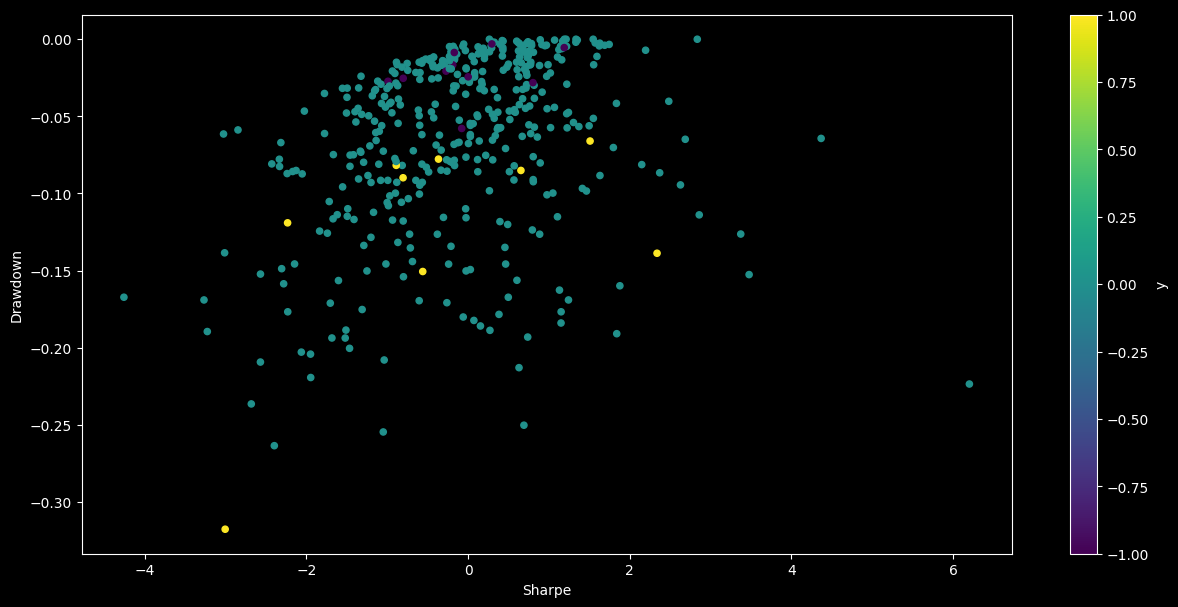

In [12]:
universe.plot.scatter(x='Sharpe', y='Drawdown', c='y')

In [13]:
features = pd.DataFrame()
features['Returns'] = universe['Returns']
features['Zscore'] = universe['Zscore']

features.head()

,Returns,Zscore
date,,
1999-03-30,-0.005834,1.433664
1999-03-31,-0.030600,0.713147
1999-04-01,-0.008102,1.367062
1999-04-22,0.017472,0.391588
1999-04-23,0.018412,0.777743


```
def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

def sharpe_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rolling_max = df['High'].rolling(window, min_periods=1).max()
    drawdown = (df['High']/rolling_max) - 1.0
    sharpe_drawdown = (sharpe * drawdown).apply(lambda v: v if v > 0 else 0)
    sharpe_drawdown_a = ta.sma(sharpe_drawdown, length=smoothing_a)
    sharpe_drawdown_b = ta.sma(sharpe_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_drawdown_a.values, sharpe_drawdown_b.values)
    # TODO: if past 5 days has signal go again
    # TODO: if past 10 days has trades closed due to Low price, and vwaps cross, go again
    

def _sharpe_rsi_drawdown(df, window):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rsi = ta.rsi(close=df['Close'], length=window)
    rolling_max = rsi.rolling(30, min_periods=1).max()
    rsi_drawdown = (rsi/rolling_max) - 1.0
    sharpe_rsi_drawdown = (sharpe * rsi_drawdown).apply(lambda v: v if v > 0 else 0)
    return sharpe_rsi_drawdown
    
def sharpe_rsi_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe_rsi_drawdown = _sharpe_rsi_drawdown(df=df, window=window)
    sharpe_rsi_drawdown_sma_a = ta.sma(sharpe_rsi_drawdown, length=smoothing_a)
    sharpe_rsi_drawdown_sma_b = ta.sma(sharpe_rsi_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_rsi_drawdown_sma_a.values, sharpe_rsi_drawdown_sma_b.values)

def rolling_stddev(df, window):
    return df['Close'].rolling(window).std()

def stoploss_line(df, window, tolerance):
    stddev = rolling_stddev(df, window)
    offset = (1.0 + tolerance) * stddev
    return df['Low'] - offset

def vwapma_line(df, length):
    vwap = ta.vwap(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
    return ta.sma(vwap, length=length)

class TQQQStrategy(Strategy):
    NAME = 'tqqq strategy'
    BUY_SIGNAL_THRESHOLD = 0.001
    STOPLOSS_TOLERANCE = 0.05
    
    def init(self):
        super().init()
        self.sharpe_drawdown_crossing = self.I(sharpe_rsi_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=10, smoothing_b=15)
        #self.b = self.I(sharpe_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=5, smoothing_b=15)
        # self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        # self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        self.vwma_5d = self.I(vwapma_line, df=self.data.df, length=5, overlay=True)
        self.vwma_20d = self.I(vwapma_line, df=self.data.df, length=10, overlay=True)
        self.stddev = self.I(rolling_stddev, df=self.data.df, window=30)
        self.stoploss = self.I(stoploss_line, df=self.data.df, window=30, tolerance=self.STOPLOSS_TOLERANCE, overlay=True)
        #self.roc = self.I(ta.roc, close=self.data.df['Close'], length=1)
        self.signal_count = 0
        
    def _signal_flag(self, flag, n=1):
        signal_off = not flag
        is_nth_signal = flag and self.signal_count == n
        return signal_off or is_nth_signal
    
    def _market_trading_down(self):
        vmwa_below = self.vwma_5d[-1] < self.vwma_20d[-1]
        open_below_vmwa = self.data.Open[-1] < self.vwma_5d[-1]
        close_below_vmwa = self.data.Close[-1] < self.vwma_5d[-1]
        return vmwa_below and close_below_vmwa #and open_below_vmwa
        
    def next(self):
        super().next()
        if self.position.size > 0:
            for trades in self.trades:
                trade_stoploss = trades.sl
                stoploss_t0 = self.stoploss[-1]
                trades.sl = max(trade_stoploss, stoploss_t0)
            
        signal = self.sharpe_drawdown_crossing[-1]
        max_signal_past_20d = max(self.sharpe_drawdown_crossing[-5:-1]) # past 10 days
        signal_memory_condition = False#not self._market_trading_down() and max_signal_past_20d >= self.BUY_SIGNAL_THRESHOLD > 0
        has_signal = signal >= self.BUY_SIGNAL_THRESHOLD or (self.position.size == 0 and signal_memory_condition)
        if has_signal:
            self.signal_count += 1
            if self._signal_flag(False):
                sl = self.stoploss[-1]
                self.buy(sl=sl, size=0.4)
            
            
#bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('TQQQ', start_date='2010-01-01', end_date='2012-01-01'), capital=10000, commission=0.002)
bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('QQQ', start_date='1995-01-01', end_date='2005-01-01'), capital=10000, commission=0.002)
stats = bt.run()
```